In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.applications import Xception
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

# Définition des répertoires et des chemins
path = '/mnt/c/Users/steph/OneDrive/Images/Rakuten/'
images_dir_train = '/mnt/c/Users/steph/OneDrive/Images/Rakuten/images/image_train/'
path_output_models = '/mnt/c/Users/steph/OneDrive/Images/Rakuten/save_data_bis/Image/'

df = pd.read_csv(path + 'df_cleaned.csv')

df.head()

,designation,description,productid,imageid,image_name,prdtypecode,Label,prdtypecode_base,text
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,image_1263597046_product_3804725264.jpg,0,Livres adultes,10,olivia personalisiertes notizbuch seiten punkt...
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,image_1008141237_product_436067568.jpg,18,Journaux et Magazines,2280,journal arts art marche salon art asiatique pa...
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,image_938777978_product_201115110.jpg,2,Accessoires de Jeux Vidéos,50,grand stylet ergonomique bleu gamepad nintendo...
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,image_457047496_product_50418756.jpg,7,Jouets pour Enfants,1280,peluche donald europe disneyland marionnette d...
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,image_1077757786_product_278535884.jpg,25,Livres,2705,guerre tuques luc grandeur veut organiser jeu ...


In [2]:
# Conversion de la colonne 'prdtypecode' en string
df['prdtypecode'] = df['prdtypecode'].astype(str)

In [3]:
# Séparation des données en ensembles d'entraînement et de validation
X_train, X_test = train_test_split(df, train_size=0.8, random_state=1234)

In [4]:
# Paramètres du modèle
img_rows = 299
img_cols = 299
batch_size = 64
dropout_rate = 0.4
l1 = 0.001

Création des générateurs de données

In [5]:
# Générateurs de données
train_datagen = ImageDataGenerator(
    rescale=1/255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    rotation_range=45,
    zoom_range=0.2,
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory=images_dir_train,
    x_col='image_name',
    y_col='prdtypecode',
    class_mode='sparse',     # image étiquetée avec un seul entier correspondant à la classe de l’image
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    shuffle=True
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=X_test,
    directory=images_dir_train,
    x_col='image_name',
    y_col='prdtypecode',
    class_mode='sparse',    # image étiquetée avec un seul entier correspondant à la classe de l’image
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    shuffle=False
)

Found 67932 validated image filenames belonging to 27 classes.
Found 16984 validated image filenames belonging to 27 classes.


In [32]:
# Création du modèle Xception
xception = Xception(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))

for layer in xception.layers:
    layer.trainable = False

# Déblocage des 70 couches du modèle xception
for layer in xception.layers[-70:]:
    layer.trainable = True

model = Sequential()
model.add(xception)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(units=27, activation='softmax'))

2023-09-13 22:53:07.596778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-13 22:53:07.777778: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


83683744/83683744 [==============================] - 3s 0us/step


In [33]:
# Compilation du modèle
learning_rate = 0.0004
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

In [7]:
# train_generator.n pour obtenir le nombre total d'images disponibles dans le générateur pour l'ensemble d'entraînement
step_size_Train = train_generator.n // train_generator.batch_size
step_size_Valid = valid_generator.n // valid_generator.batch_size

#check_file_name = 'checkpoint_Xception_model.h5'

Callbacks

In [18]:
# Sauvegarde des meilleurs poids du modèle au cours de l'entraînement :
model_checkpoint = ModelCheckpoint(filepath=path_output_models + "checkpoint_Xception_model.h5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='max',
                             save_freq='epoch')

# Sauvegarde des poids (.h5)
weights_checkpoint = ModelCheckpoint(filepath=path_output_models + "weights_xception.h5",
                                      monitor='val_accuracy',
                                      verbose=1, 
                                      save_best_only=True,
                                      save_weights_only=True,  # True pour sauvegarder uniquement les poids
                                      mode='max',
                                      save_freq='epoch')

# Réduction automatiquement le learning rate
early_stopping = EarlyStopping(monitor='val_loss',
                      min_delta=0,
                      patience=2,
                      restore_best_weights=True,
                      verbose=1,
                      mode='min')

# Arrêt de l'entraînement si le modèle n'évolue plus
lr_plateau = ReduceLROnPlateau(patience=2,
                              verbose=1)

callbacks = [model_checkpoint, weights_checkpoint, early_stopping, lr_plateau]

In [19]:
# chargement du modèle
#model = load_model('/mnt/c/Users/steph/OneDrive/Images/Rakuten/save_data_bis/Image/checkpoint_Xception_model.h5')

Entraînement

In [20]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    epochs=25,
    callbacks=[model_checkpoint, weights_checkpoint, early_stopping, lr_plateau]
)

Epoch 1/25
1061/1061 [==============================] - ETA: 0s - loss: 1.3305 - accuracy: 0.7260
Epoch 1: val_accuracy improved from -inf to 0.64941, saving model to /mnt/c/Users/steph/OneDrive/Images/Rakuten/save_data_bis/Image/model_xception1.h5


/home/steph/workspace/rakuten_env/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 1: val_accuracy improved from -inf to 0.64941, saving model to /mnt/c/Users/steph/OneDrive/Images/Rakuten/save_data_bis/Image/weights_xception.h5
1061/1061 [==============================] - 4019s 4s/step - loss: 1.3305 - accuracy: 0.7260 - val_loss: 1.6512 - val_accuracy: 0.6494 - lr: 4.0000e-04
Epoch 2/25
1061/1061 [==============================] - ETA: 0s - loss: 1.2770 - accuracy: 0.7413
Epoch 2: val_accuracy improved from 0.64941 to 0.65607, saving model to /mnt/c/Users/steph/OneDrive/Images/Rakuten/save_data_bis/Image/model_xception1.h5

Epoch 2: val_accuracy improved from 0.64941 to 0.65607, saving model to /mnt/c/Users/steph/OneDrive/Images/Rakuten/save_data_bis/Image/weights_xception.h5
1061/1061 [==============================] - 4019s 4s/step - loss: 1.2770 - accuracy: 0.7413 - val_loss: 1.6266 - val_accuracy: 0.6561 - lr: 4.0000e-04
Epoch 3/25
1061/1061 [==============================] - ETA: 0s - loss: 1.2177 - accuracy: 0.7544
Epoch 3: val_accuracy did not improve

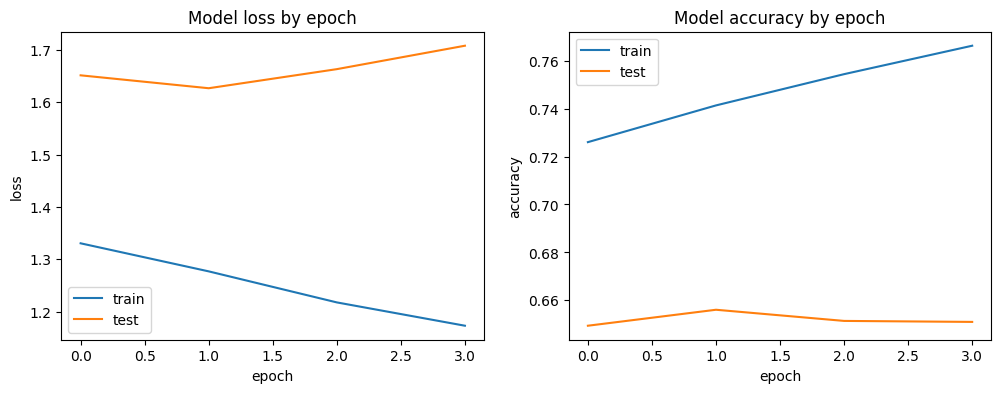

In [21]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Evaluation

In [22]:
# Évaluation du modèle
valid_score = model.evaluate(valid_generator)
print("Model metrics names:", model.metrics_names)
print("Accuracy: {:.2f}%".format(valid_score[1] * 100))
print("Loss: ", valid_score[0])
sc = valid_score[0]

266/266 [==============================] - 413s 2s/step - loss: 1.6267 - accuracy: 0.6561
Model metrics names: ['loss', 'accuracy']
Accuracy: 65.61%
Loss:  1.6266762018203735


In [24]:
# Prédiction sur l'ensemble de validation
y_pred_proba = model.predict(valid_generator)
y_pred_class = np.argmax(y_pred_proba, axis=1).astype(int)
y_true = valid_generator.classes

266/266 [==============================] - 423s 2s/step


In [25]:
# Métriques de classification
f1_macro = f1_score(y_true, y_pred_class, average='macro')
f1_micro = f1_score(y_true, y_pred_class, average='micro')
f1_weighted = f1_score(y_true, y_pred_class, average='weighted')
classification_rep = classification_report(y_true, y_pred_class)

In [26]:
print("[INFO] f1 score macro average: ", f1_macro)
print("[INFO] f1 score micro average: ", f1_micro)
print("[INFO] f1 score weighted average: ", f1_weighted)
print(classification_rep)

[INFO] f1 score macro average:  0.6051102049739717
[INFO] f1 score micro average:  0.6560880829015544
[INFO] f1 score weighted average:  0.6516187628037551
              precision    recall  f1-score   support

           0       0.64      0.60      0.62       643
           1       0.60      0.63      0.61       503
           2       0.80      0.52      0.63       162
           3       0.40      0.57      0.47       514
           4       0.52      0.53      0.52       664
           5       0.64      0.55      0.59       993
           6       0.81      0.84      0.82       832
           7       0.76      0.61      0.68       159
           8       0.47      0.58      0.52       970
           9       0.68      0.26      0.38       190
          10       0.72      0.81      0.76       911
          11       0.75      0.63      0.69       961
          12       0.39      0.40      0.40       319
          13       0.69      0.58      0.63       301
          14       0.74      0.68

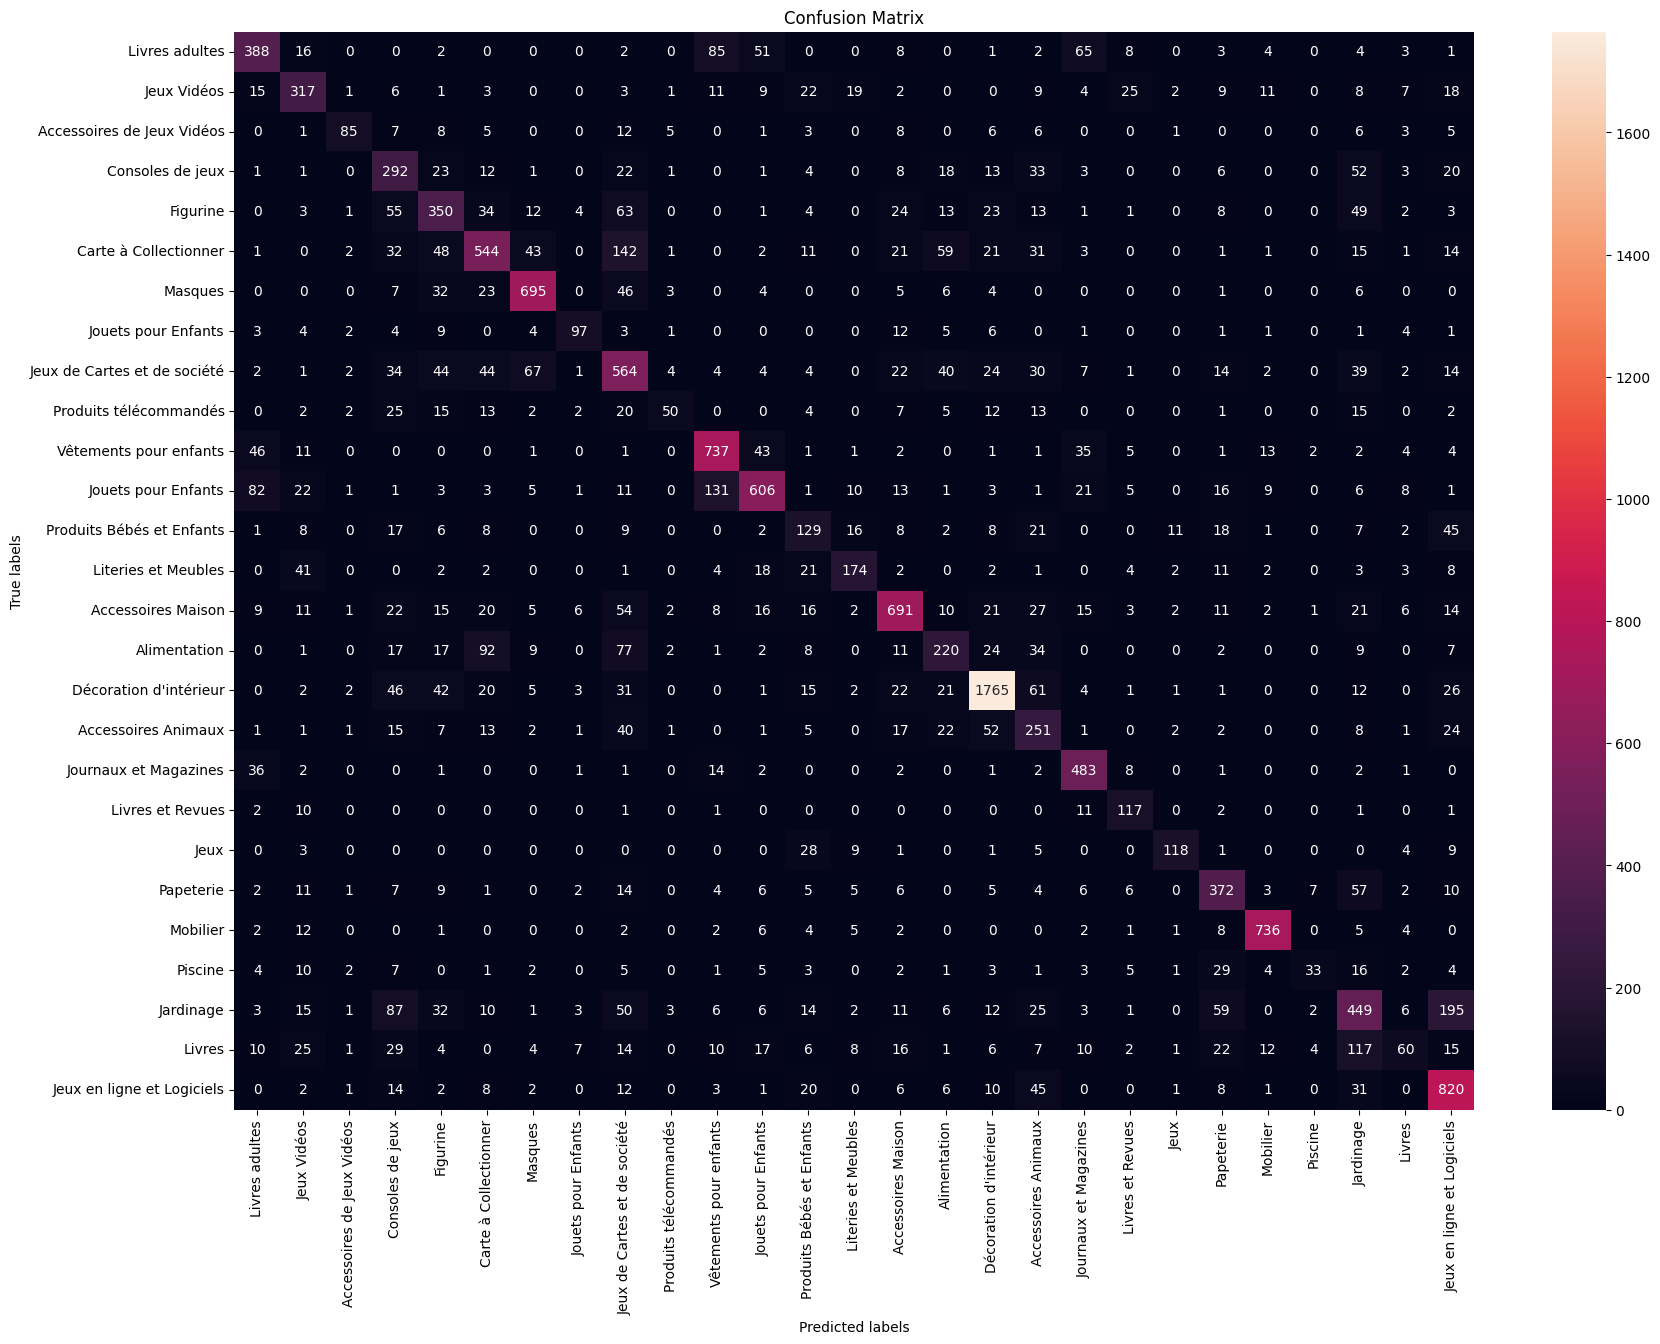

In [27]:
# Matrice de confusion
matrix = confusion_matrix(y_true, y_pred_class)

# liste des labels
labels = ["Livres adultes", "Jeux Vidéos", "Accessoires de Jeux Vidéos", "Consoles de jeux", "Figurine", "Carte à Collectionner",
          "Masques", "Jouets pour Enfants", "Jeux de Cartes et de société", "Produits télécommandés",
          "Vêtements pour enfants", "Jouets pour Enfants", "Produits Bébés et Enfants",
          "Literies et Meubles", "Accessoires Maison", "Alimentation", "Décoration d'intérieur", "Accessoires Animaux",
          "Journaux et Magazines", "Livres et Revues", "Jeux", "Papeterie",
          "Mobilier", "Piscine", "Jardinage", "Livres", "Jeux en ligne et Logiciels"]

plt.figure(figsize=(20, 14))
ax = plt.subplot()
sns.heatmap(matrix, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

plt.show()

Prédictions

image file name :  image_907794536_product_91920807.jpg
1/1 [==============================] - 0s 87ms/step


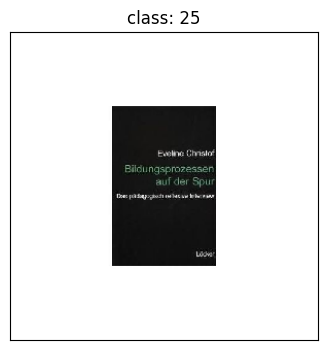

In [ ]:
row_id = 6
img_path = images_dir_train + df['image_name'][row_id]
print('image file name : ', df['image_name'][row_id])
img = image.load_img(img_path, target_size=(299, 299))
plt.figure(figsize=(6, 4))
plt.imshow(img)

# Classe prédite
im = cv2.resize(cv2.imread(img_path), (299, 299))
im = im / 255
im = np.expand_dims(im, axis=0)
out = model.predict(im)
im_pred = np.argmax(out)

# Fonction pour obtenir la classe réelle à partir de l'indice prédit
def get_real_class(val):
    for real_cls, gen_label in valid_generator.class_indices.items():
        if val == gen_label:
            return real_cls
    return None

# Affichage avec la classe réelle
real_class = get_real_class(im_pred)
plt.title("class: " + str(real_class))

plt.xticks([])
plt.yticks([])
plt.show()


image file name :  image_1216404223_product_3397499315.jpg


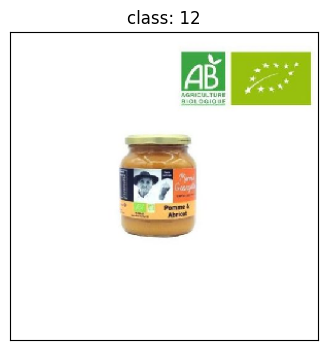

1/1 [==============================] - 0s 466ms/step


In [ ]:
# Prédiction sur un échantillon
row_id = 230
img_path = images_dir_train + df['image_name'][row_id]
print('image file name : ', df['image_name'][row_id])
img = image.load_img(img_path, target_size=(299, 299))
plt.figure(figsize=(6, 4))
plt.imshow(img)
plt.title("class: " + str(df['prdtypecode'][row_id]))
plt.xticks([])
plt.yticks([])
plt.show()

im = cv2.resize(cv2.imread(img_path), (299, 299))
im = im / 255
im = np.expand_dims(im, axis=0)
out = model.predict(im)
im_pred = np.argmax(out)

def get_real_class(val):
    for real_cls, gen_label in valid_generator.class_indices.items():
        if val == gen_label:
            return real_cls
    return None


Type de l'image :  uint8


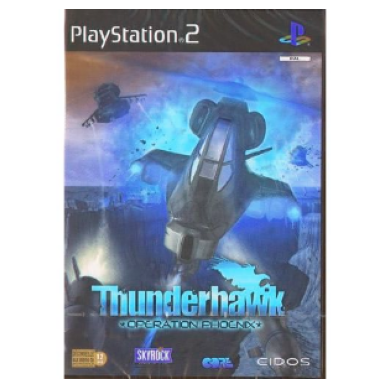

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Chemin de l'image que vous souhaitez prédire
img_path = '/mnt/c/Users/steph/OneDrive/Images/Rakuten/images/image_test/image_529140_product_923202.jpg'

# Chargement de l'image avec OpenCV en utilisant cv2.IMREAD_COLOR
img = cv2.imread(img_path, cv2.IMREAD_COLOR)

# Vérification du type de l'image
print("Type de l'image : ", img.dtype)

# Redimensionnement de l'image aux dimensions d'entrée du modèle (299x299)
img = cv2.resize(img, (299, 299))

# profondeur de l'image en 64 bits (CV_64F) : conversion en RVB avec cv2.IMREAD_COLOR non pris en charge 
# modification de la profondeur de l'image en 8 bits (CV_8U) 
img = img.astype(np.uint8)

# Normalisation de l'image 
img = img / 255.0

# Ajout d'une dimension pour correspondre aux attentes du modèle
img = np.expand_dims(img, axis=0)

# Affichage
plt.imshow(img[0])
plt.axis('off') 
plt.show()


In [ ]:
# Prédiction avec le modèle xception
predictions = model.predict(img)

# Classe prédite en utilisant argmax
predicted_class = np.argmax(predictions, axis=1)

# Probabilité pour chaque classe
class_probabilities = predictions[0]

# Affichez les résultats
print("Classe prédite :", predicted_class)
print("Probabilités de classe :", class_probabilities)


1/1 [==============================] - 0s 86ms/step
Classe prédite : [1]
Probabilités de classe : [5.8806967e-05 9.4009578e-01 2.7811247e-06 6.6793377e-06 1.6000679e-07
 5.6964785e-07 5.0293231e-08 4.4574105e-07 7.7879340e-06 2.1731329e-07
 9.7987257e-05 1.7763113e-04 2.3887602e-03 4.4925939e-02 2.6263882e-05
 1.6215890e-06 1.2450603e-07 2.2968877e-06 1.2820408e-05 7.3060058e-03
 1.5565519e-03 2.4685496e-04 2.7246395e-04 1.9635362e-04 3.6883607e-04
 2.1941680e-03 5.2082793e-05]
